### Preprocess Text Data and Modelling 
### ANLY 590 Project


***

#### Prep

In [0]:
# set working directory
import os
import sys
path = '/Users/kgedney/Documents/georgetown/anly590/author-id-project'
os.chdir(path)

In [0]:
import numpy as np
import pandas as pd

In [0]:
# load filtered data
df = pd.read_csv('filtered_data.csv')

#### Google Colab Prep

In [0]:
import numpy as np
import pandas as pd

In [1]:
# get data from Google drive
from google.colab import drive
drive.mount('/content/gdrive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/gdrive


In [3]:
# manually add file from local to drive
df = pd.read_csv('filtered_data.csv')
df.head()

,author,body,subreddit,permalink,num_chars,num_words
0,GuaranteedAdmission,News aggregators don't filter Opinion pieces i...,AskAnAmerican,/r/AskAnAmerican/comments/9zrnid/america_whats...,69,11
1,GuaranteedAdmission,You can be in favor of a policy he supports an...,AskReddit,/r/AskReddit/comments/9zklcs/as_a_brit_who_onl...,74,17
2,GuaranteedAdmission,That depends. What is the penalty for breaking...,AskReddit,/r/AskReddit/comments/9zkfcd/how_would_you_fee...,202,36
3,GuaranteedAdmission,Because I like to think long term. Tax cuts fo...,AskReddit,/r/AskReddit/comments/9yxl98/liberals_of_reddi...,120,22
4,GuaranteedAdmission,"We don't talk about the Highway Shoes, OP! Are...",AskReddit,/r/AskReddit/comments/9yrbvd/people_who_lost_a...,110,22


In [4]:
# download nltk
import nltk
nltk.download('popular')

[nltk_data] Downloading collection 'popular'
[nltk_data]    | 
[nltk_data]    | Downloading package cmudict to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/cmudict.zip.
[nltk_data]    | Downloading package gazetteers to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gazetteers.zip.
[nltk_data]    | Downloading package genesis to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/genesis.zip.
[nltk_data]    | Downloading package gutenberg to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/gutenberg.zip.
[nltk_data]    | Downloading package inaugural to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/inaugural.zip.
[nltk_data]    | Downloading package movie_reviews to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping corpora/movie_reviews.zip.
[nltk_data]    | Downloading package names to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/names.zip.
[nltk_data]    | Downloading package shakespeare to /root/nltk_data...
[nlt

True

#### Text Cleaning

ref: https://www.analyticsvidhya.com/blog/2018/02/the-different-methods-deal-text-data-predictive-python/

In [0]:
# remove URLs and replace as '<url>'
import re
df['body_no_urls'] = df.apply(lambda row: re.sub(r"http\S+", "<url>", row['body']), axis=1) 

In [0]:
# tokenize
from nltk.tokenize import word_tokenize
df['tokenized_nltk']  = df.apply(lambda row: word_tokenize(row['body_no_urls']), axis=1)

In [0]:
# remove NERs

In [0]:
# import spacy
# nlp = spacy.load('en')

In [0]:
# def get_ners(input_doc):
#     doc = nlp(input_doc)
#     ners = str(doc.ents)
#     return (ners)

***

#### Preprocess  for Modelling

In [7]:
# install packages
import numpy as np

from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

import keras
from keras import optimizers
import tensorflow as tf

from keras.utils import np_utils
from keras.preprocessing import sequence
from keras.preprocessing.text import Tokenizer

from keras.models import Model, Sequential
from keras.layers import Input, Dense, CuDNNLSTM, LSTM, Embedding, Bidirectional, GlobalAveragePooling1D, Conv1D, Activation, Flatten, Dropout, MaxPooling1D, Embedding, GlobalMaxPooling1D

from keras.layers.core import Dense, Dropout

Using TensorFlow backend.


In [0]:
# create class assignments
df['author_id'] = pd.Categorical(df.author).codes

#### 0. Baseline Model: Linear SVM

In [41]:
x = df['body_no_urls'].values
y = df['author_id'].values

x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.20, random_state=22)

tfidf_vec   = TfidfVectorizer()
x_train_vec = tfidf_vec.fit_transform(x_train)
x_test_vec  = tfidf_vec.transform(x_test)
x_train_vec.shape

(58129, 53161)

In [0]:
from sklearn.svm import LinearSVC
clf             = LinearSVC().fit(x_train_vec, y_train)
predicted       = clf.predict(x_test_vec)
predicted_score = clf.decision_function(x_test_vec)

In [43]:
print('accuracy', metrics.accuracy_score(y_test, predicted))

accuracy 0.37789857565540497


In [44]:
train_predicted = clf.predict(x_train_vec)
train_predicted_score = clf.decision_function(x_train_vec)

print('train accuracy', metrics.accuracy_score(y_train, train_predicted))

train accuracy 0.9905382855373394


In [45]:
# top k accuracy (# ref: https://scikit-learn.org/stable/modules/svm.html)
predicted_score = clf.decision_function(x_test_vec)
predicted_score.shape

(14533, 100)

In [0]:
# transform matrix of predictions to put them in order
best_n = predicted_score.argsort()[:,::-1] # need to do in reverse order thats why need "[::-1]"

In [47]:
# set up function to calculate top 5
count = 0
for i in range(0, y_test.shape[0]):
    if (y_test[i] in best_n[i,0:5]):
        count = count + 1

top_5_acc = count / y_test.shape[0]
top_5_acc

0.5871464941856465

In [48]:
# set up function to calculate top 10
count = 0
for i in range(0, y_test.shape[0]):
    if (y_test[i] in best_n[i,0:10]):
        count = count + 1

top_10_acc = count / y_test.shape[0]
top_10_acc

0.6836854056285695

#### Preprocess Data for Keras Models

In [52]:
# data preprocess
x = df['tokenized_nltk'].values
y = df['author_id'].values

# create sequences
max_features = 25000
tokenizer    = Tokenizer(num_words = max_features)
tokenizer.fit_on_texts(x)
x_sequences  = tokenizer.texts_to_sequences(x)

# pad each sequence to be max length
maxlen = max(len(x) for x in x_sequences)
print(maxlen)
x_sequences = sequence.pad_sequences(x_sequences, maxlen)

236


In [0]:
# from keras.utils import to_categorical
# print(y.shape)
# y = to_categorical(y)
# print(y.shape)

In [0]:
# split test and train
x_train, x_test, y_train, y_test = train_test_split(x_sequences, y, test_size=0.20, random_state=22)

#### 1. Faster RNN Model: CuDNNLSTM 

- Run on Google Colab, 14 mins.    
- Very overfit

In [0]:
# ref: https://keras.io/layers/recurrent/#cudnnlstm
# faster LSTM implementation

model1 = Sequential()
model1.add(Embedding(input_dim=max_features,
                     output_dim=128))
model1.add(CuDNNLSTM(128))
model1.add(Dropout(0.5))
model1.add(Dense(100, activation="softmax"))

model1.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [12]:
history1 = model1.fit(x_train, y_train,
            batch_size=128,
            epochs=16,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/16
58129/58129 [==============================] - 32s 553us/step - loss: 4.4084 - acc: 0.0360 - val_loss: 4.1502 - val_acc: 0.0628
Epoch 2/16
58129/58129 [==============================] - 28s 477us/step - loss: 3.9708 - acc: 0.0874 - val_loss: 3.8838 - val_acc: 0.1061
Epoch 3/16
58129/58129 [==============================] - 28s 477us/step - loss: 3.5852 - acc: 0.1513 - val_loss: 3.6819 - val_acc: 0.1499
Epoch 4/16
58129/58129 [==============================] - 28s 477us/step - loss: 3.2119 - acc: 0.2258 - val_loss: 3.5906 - val_acc: 0.1806
Epoch 5/16
58129/58129 [==============================] - 28s 478us/step - loss: 2.8439 - acc: 0.3056 - val_loss: 3.5279 - val_acc: 0.2073
Epoch 6/16
58129/58129 [==============================] - 28s 480us/step - loss: 2.4908 - acc: 0.3859 - val_loss: 3.5939 - val_acc: 0.2199
Epoch 7/16
58129/58129 [==============================] - 28s 481us/step - loss: 2.1779 - acc: 0.4590 - val_loss: 3.

In [13]:
print('accuracy', model1.evaluate(x_test, y_test)[1])

14533/14533 [==============================] - 6s 431us/step
accuracy 0.2393174155370536


In [14]:
print('accuracy', model1.evaluate(x_train, y_train)[1])

58129/58129 [==============================] - 25s 428us/step
accuracy 0.9098728689669324


#### 2. CNN

In [0]:
model_conv2 = Sequential()
model_conv2.add(Embedding(max_features, output_dim=128, input_length=236))
model_conv2.add(Dropout(0.2))
model_conv2.add(Conv1D(128, 5, activation='relu'))
model_conv2.add(Conv1D(128, 5, activation='relu'))
model_conv2.add(GlobalMaxPooling1D())
model_conv2.add(Dropout(0.2))
model_conv2.add(Dense(100, activation='softmax'))

In [0]:
from keras import optimizers
opt = optimizers.rmsprop(lr=0.001) # speed up optimization
model_conv2.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["acc"])


In [128]:
history2 = model_conv2.fit(x_train, y_train,
            batch_size=128,
            epochs=16,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/16
58129/58129 [==============================] - 16s 272us/step - loss: 4.3897 - acc: 0.0377 - val_loss: 4.1839 - val_acc: 0.0667
Epoch 2/16
58129/58129 [==============================] - 14s 249us/step - loss: 4.0557 - acc: 0.0873 - val_loss: 3.9225 - val_acc: 0.1111
Epoch 3/16
58129/58129 [==============================] - 14s 249us/step - loss: 3.7756 - acc: 0.1319 - val_loss: 3.7115 - val_acc: 0.1501
Epoch 4/16
58129/58129 [==============================] - 14s 249us/step - loss: 3.5248 - acc: 0.1760 - val_loss: 3.5996 - val_acc: 0.1734
Epoch 5/16
58129/58129 [==============================] - 14s 249us/step - loss: 3.2894 - acc: 0.2214 - val_loss: 3.5324 - val_acc: 0.1920
Epoch 6/16
58129/58129 [==============================] - 15s 250us/step - loss: 3.0699 - acc: 0.2655 - val_loss: 3.5113 - val_acc: 0.2031
Epoch 7/16
58129/58129 [==============================] - 14s 249us/step - loss: 2.8584 - acc: 0.3103 - val_loss: 3.

In [18]:
model_conv2.evaluate(x_test,y_test)


14533/14533 [==============================] - 2s 105us/step


[3.4621874713556475, 0.23243652377450638]

In [26]:
print('train accuracy', model_conv2.evaluate(x_train, y_train)[1])

58129/58129 [==============================] - 6s 95us/step
train accuracy 0.502554662905431


#### 3. CNN + LSTM

In [0]:
model_conv3 = Sequential()
model_conv3.add(Embedding(max_features, output_dim=128, input_length=236))
model_conv3.add(Dropout(0.2))
model_conv3.add(Conv1D(128, 5, activation='relu'))
model_conv3.add(MaxPooling1D(4))
model_conv3.add(LSTM(100))
#model_conv.add(GlobalMaxPooling1D())

model_conv3.add(Dense(100, activation='softmax'))

In [0]:
opt = optimizers.rmsprop(lr=0.001) # speed up optimization
model_conv3.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["acc"])

In [21]:
history3 = model_conv3.fit(x_train, y_train,
            batch_size=128,
            epochs=16,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/16
58129/58129 [==============================] - 76s 1ms/step - loss: 4.4075 - acc: 0.0308 - val_loss: 4.2653 - val_acc: 0.0467
Epoch 2/16
58129/58129 [==============================] - 75s 1ms/step - loss: 4.1108 - acc: 0.0716 - val_loss: 4.1370 - val_acc: 0.0672
Epoch 3/16
58129/58129 [==============================] - 74s 1ms/step - loss: 3.8278 - acc: 0.1164 - val_loss: 3.8858 - val_acc: 0.1108
Epoch 4/16
58129/58129 [==============================] - 76s 1ms/step - loss: 3.6038 - acc: 0.1534 - val_loss: 3.7150 - val_acc: 0.1388
Epoch 5/16
58129/58129 [==============================] - 75s 1ms/step - loss: 3.4445 - acc: 0.1797 - val_loss: 3.6758 - val_acc: 0.1499
Epoch 6/16
58129/58129 [==============================] - 75s 1ms/step - loss: 3.2954 - acc: 0.2118 - val_loss: 3.5813 - val_acc: 0.1726
Epoch 7/16
58129/58129 [==============================] - 75s 1ms/step - loss: 3.1584 - acc: 0.2381 - val_loss: 3.6019 - val_acc

In [22]:
model_conv3.evaluate(x_test, y_test)


14533/14533 [==============================] - 28s 2ms/step


[3.453166136941455, 0.2364962499150142]

In [24]:
print("training acc", model_conv3.evaluate(x_train, y_train))


58129/58129 [==============================] - 105s 2ms/step
training acc [1.9474374311162956, 0.52392093447589]


#### 4. Simple Pooling Model

In [0]:
#ref: https://github.com/keras-team/keras/blob/master/examples/imdb_fasttext.py

In [0]:
model4 = Sequential()
model4.add(Embedding(input_dim=max_features,
                    output_dim=128))

# we add a GlobalAveragePooling1D, which will average the embeddings
# of all words in the document
model4.add(GlobalAveragePooling1D())
model4.add(Dropout(0.5))

model4.add(Dense(100, activation="softmax"))

In [0]:
opt = keras.optimizers.Adam(lr=0.01) # speed up optimization
model4.compile(optimizer=opt, loss="sparse_categorical_crossentropy", metrics=["acc"])

In [57]:
history4 = model4.fit(x_train, y_train,
            batch_size=256,
            epochs=16,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/16
58129/58129 [==============================] - 3s 58us/step - loss: 4.4577 - acc: 0.0426 - val_loss: 4.2268 - val_acc: 0.1050
Epoch 2/16
58129/58129 [==============================] - 3s 45us/step - loss: 3.9847 - acc: 0.1355 - val_loss: 3.7686 - val_acc: 0.1907
Epoch 3/16
58129/58129 [==============================] - 3s 45us/step - loss: 3.5185 - acc: 0.2289 - val_loss: 3.4095 - val_acc: 0.2645
Epoch 4/16
58129/58129 [==============================] - 3s 45us/step - loss: 3.1185 - acc: 0.3144 - val_loss: 3.1559 - val_acc: 0.3103
Epoch 5/16
58129/58129 [==============================] - 3s 45us/step - loss: 2.7910 - acc: 0.3830 - val_loss: 2.9912 - val_acc: 0.3399
Epoch 6/16
58129/58129 [==============================] - 3s 45us/step - loss: 2.5084 - acc: 0.4455 - val_loss: 2.8619 - val_acc: 0.3588
Epoch 7/16
58129/58129 [==============================] - 3s 45us/step - loss: 2.2644 - acc: 0.4988 - val_loss: 2.7477 - val_acc

In [58]:
print('accuracy', model4.evaluate(x_test, y_test)[1])

14533/14533 [==============================] - 1s 52us/step
accuracy 0.41711965870879386


In [59]:
print('train accuracy', model4.evaluate(x_train, y_train)[1])

58129/58129 [==============================] - 3s 52us/step
train accuracy 0.889143112737154


#### Plots + Compare Models

In [0]:
import seaborn as sns
import matplotlib.pyplot as plt
sns.set_style("ticks")

##### Plot Test and Train

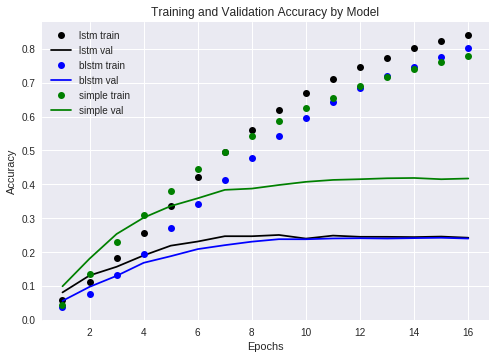

In [0]:
# plot test vs. train to show overfitting!

# Get values 
acc1     = history1.history['acc']
val_acc1 = history1.history['val_acc']

acc2     = history2.history['acc']
val_acc2 = history2.history['val_acc']

acc3     = history3.history['acc']
val_acc3 = history3.history['val_acc']


# Setup grid for plotting
epochs = range(1, len(acc) + 1)

# plot model 1
plt.plot(epochs, acc1, 'bo', label='lstm train', color='k')
plt.plot(epochs, val_acc1, 'b', label='lstm val', color='k')

# plot model 2
plt.plot(epochs, acc2, 'bo', label='blstm train', color='b')
plt.plot(epochs, val_acc2, 'b', label='blstm val', color='b')

# plot model 3
plt.plot(epochs, acc3, 'bo', label='simple train', color='g')
plt.plot(epochs, val_acc3, 'b', label='simple val', color='g')

plt.title('Training and Validation Accuracy by Model')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

##### Plot Accuracy by Author

In [70]:
# plot accuracy rates by author from best model
from sklearn.metrics import classification_report, accuracy_score, confusion_matrix
import numpy as np

y_pred4 = model4.predict_classes(x_test)
# print(classification_report(y_test, y_pred4))

cm = confusion_matrix(y_test, y_pred4) # only works with sparse
cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
accuracies = cm.diagonal()
accuracies

array([0.36      , 0.75903614, 0.4214876 , 0.23972603, 0.51176471,
       0.31428571, 0.17213115, 0.36507937, 0.35820896, 0.30322581,
       0.52469136, 0.40909091, 0.37735849, 0.16666667, 0.45806452,
       0.47333333, 0.47770701, 0.21428571, 0.60483871, 0.34883721,
       0.41984733, 0.6557377 , 0.48760331, 0.4084507 , 0.49285714,
       0.27941176, 0.46616541, 0.38059701, 0.34057971, 0.38607595,
       0.46706587, 0.53125   , 0.57065217, 0.41803279, 0.45588235,
       0.20714286, 0.2195122 , 0.6097561 , 0.68862275, 0.37341772,
       0.48760331, 0.49494949, 0.32484076, 0.2519084 , 0.57386364,
       0.3715847 , 0.24858757, 0.38095238, 0.33962264, 0.42207792,
       0.6       , 0.2885906 , 0.71929825, 0.41104294, 0.38271605,
       0.40206186, 0.32824427, 0.54069767, 0.28070175, 0.28301887,
       0.46666667, 0.65591398, 0.58100559, 0.35833333, 0.43884892,
       0.40425532, 0.375     , 0.40659341, 0.8       , 0.31914894,
       0.38345865, 0.44565217, 0.62721893, 0.2890625 , 0.20645

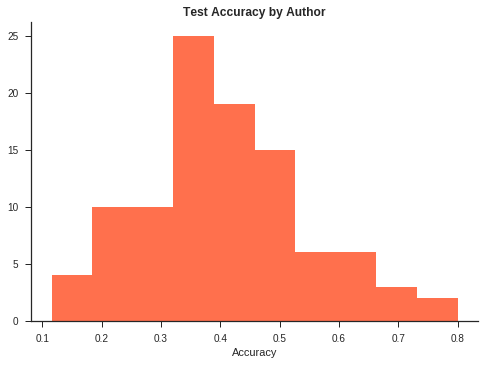

In [88]:
plt.hist(accuracies, bins=10, color='#ff704d')
plt.title('Test Accuracy by Author', fontweight="bold")
plt.xlabel('Accuracy')
sns.despine()
plt.show()

##### Top K Analysis

In [0]:
# get predictions for each DL model
y_pred1 = model1.predict_classes(x_test)
y_pred2 = model_conv2.predict_classes(x_test)
y_pred3 = model_conv3.predict_classes(x_test)
y_pred4 = model4.predict_classes(x_test)

# get scores - basically the softmax output
test_scores1 = model1.predict(x_test) 
test_scores2 = model_conv2.predict(x_test) 
test_scores3 = model_conv3.predict(x_test) 
test_scores4 = model4.predict(x_test) 

In [0]:
def topk_acc(y_test, y_pred, k):
  return keras.backend.eval(keras.metrics.sparse_top_k_categorical_accuracy(y_test, y_pred, k=k)) # force it to evaluate

topk1 = [(k, topk_acc(y_test, test_scores1, k=k)) for k in range(1, 51)]
topk2 = [(k, topk_acc(y_test, test_scores2, k=k)) for k in range(1, 51)]
topk3 = [(k, topk_acc(y_test, test_scores3, k=k)) for k in range(1, 51)]
topk4 = [(k, topk_acc(y_test, test_scores4, k=k)) for k in range(1, 51)]

In [107]:
topk1[0:10]

[(1, 0.23931742),
 (2, 0.31913576),
 (3, 0.3695039),
 (4, 0.41085804),
 (5, 0.4434735),
 (6, 0.46872634),
 (7, 0.49267185),
 (8, 0.5139338),
 (9, 0.53292507),
 (10, 0.55157226)]

In [38]:
topk2[0:10]

[(1, 0.23243652),
 (2, 0.3217505),
 (3, 0.37755454),
 (4, 0.41863346),
 (5, 0.45228103),
 (6, 0.48592857),
 (7, 0.5148283),
 (8, 0.53794813),
 (9, 0.56024224),
 (10, 0.5800592)]

In [39]:
topk3[0:10]

[(1, 0.23649625),
 (2, 0.3278057),
 (3, 0.387463),
 (4, 0.43267047),
 (5, 0.46886396),
 (6, 0.49728206),
 (7, 0.5262506),
 (8, 0.5493704),
 (9, 0.5723526),
 (10, 0.59141266)]

In [40]:
topk4[0:10]

[(1, 0.42179868),
 (2, 0.5168926),
 (3, 0.57138926),
 (4, 0.60985345),
 (5, 0.64067984),
 (6, 0.6689603),
 (7, 0.6922177),
 (8, 0.7110025),
 (9, 0.72744787),
 (10, 0.74334276)]

In [0]:
# plot results
k_values = [k for k in range(1,51)]

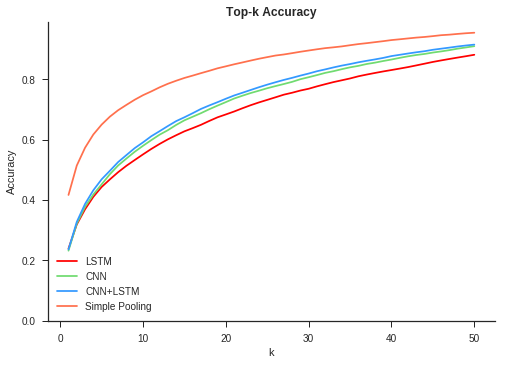

In [152]:
plt.plot(k_values, [k[1] for k in topk1], 'b', label='LSTM', color='r')
plt.plot(k_values, [k[1] for k in topk2], 'b', label='CNN', color='#70db70')
plt.plot(k_values, [k[1] for k in topk3], 'b', label='CNN+LSTM', color='#3399ff')
plt.plot(k_values, [k[1] for k in topk4], 'b', label='Simple Pooling', color='#ff704d')

plt.title('Top-k Accuracy', fontweight="bold")
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.legend()
plt.ylim(ymin=0)
sns.despine()
plt.show()

##### Best Author Analysis

In [0]:
# lots of politics, and very consistent writing style
print(accuracies.max())
print(accuracies.argmax())
print(df[['author', 'body']][df['author_id'] == 68][0:5])

0.7517241379310344
68
      author                                               body
9346  djphan  Kansas is an underrated pickup opportunity... ...
9347  djphan  how can i point to their argument without usin...
9348  djphan  i did.. i see the subsequent comments... and t...
9349  djphan  i literally quoted it in my first reply...  \n...
9350  djphan  youre saying that clinton did it herself... th...


In [122]:
# check best author LSTM
cm_1 = confusion_matrix(y_test, y_pred1) # only works with sparse
cm_1 = cm_1.astype('float') / cm_1.sum(axis=1)[:, np.newaxis]
accuracies_1 = cm.diagonal()
accuracies_1
print(accuracies_1.argmax())

68


##### Author and Post Length Analysis

In [0]:
y_pred4 = model4.predict_classes(x_test)

In [0]:
x_test_length = (x_test != 0).sum(axis=1) 

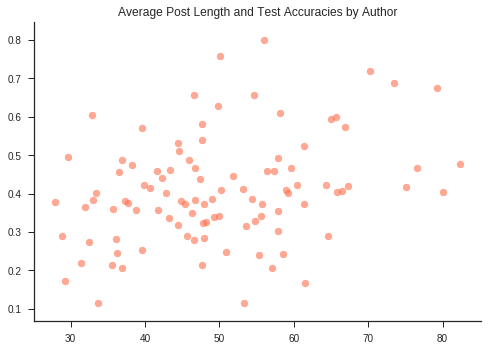

In [138]:
length_by_author = pd.Series(x_test_length).groupby(y_test).mean() #avg post length, in tokens
acc_by_author    = pd.Series(y_pred4 == y_test).groupby(y_test).mean()

plt.scatter(length_by_author, acc_by_author, alpha=0.6)
plt.title('Average Post Length and Test Accuracies by Author')
sns.despine()
plt.show()

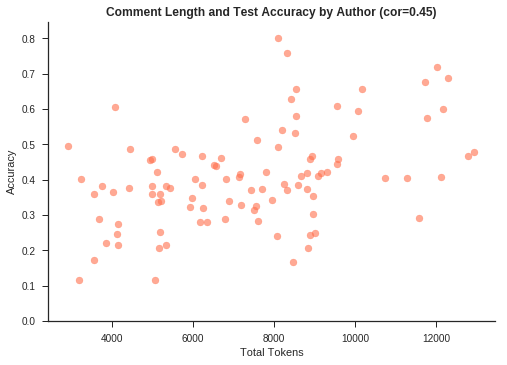

In [151]:
length_by_author = pd.Series(x_test_length).groupby(y_test).sum() # take sum
acc_by_author    = pd.Series(y_pred4 == y_test).groupby(y_test).mean()

plt.scatter(length_by_author, acc_by_author, alpha=0.6, color='#ff704d')
plt.title('Comment Length and Test Accuracy by Author (cor=0.45)', fontweight="bold")
plt.ylabel('Accuracy')
plt.xlabel('Total Tokens')
plt.ylim(ymin=0)
sns.despine()
plt.show()

In [148]:
np.corrcoef(length_by_author, acc_by_author)

array([[1.        , 0.44552191],
       [0.44552191, 1.        ]])

#### Save Models

In [0]:
model1.save('/content/gdrive/My Drive/colab/anly-author-id/model_l.h5')
model2.save('/content/gdrive/My Drive/colab/anly-author-id/model_2.h5')
model3.save('/content/gdrive/My Drive/colab/anly-author-id/model_3.h5')

#### EXTRA. Multilayer

In [0]:
# Multilayer LSTM
model5 = Sequential()
model5.add(Embedding(input_dim=max_features,
                    output_dim=128))

model5.add(CuDNNLSTM(128, return_sequences=True))
model5.add(Dropout(0.5))

model5.add(CuDNNLSTM(64))
model5.add(Dropout(0.5))

model5.add(Dense(100, activation="softmax"))

model5.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [0]:
history5 = model5.fit(x_train, y_train,
            batch_size=256,
            epochs=16,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/16
58129/58129 [==============================] - 46s 797us/step - loss: 4.4563 - acc: 0.0301 - val_loss: 4.2198 - val_acc: 0.0588
Epoch 2/16
58129/58129 [==============================] - 44s 764us/step - loss: 4.1062 - acc: 0.0710 - val_loss: 3.9898 - val_acc: 0.0962
Epoch 3/16
58129/58129 [==============================] - 44s 756us/step - loss: 3.8289 - acc: 0.1135 - val_loss: 3.7824 - val_acc: 0.1303
Epoch 4/16
58129/58129 [==============================] - 44s 765us/step - loss: 3.6063 - acc: 0.1513 - val_loss: 3.6834 - val_acc: 0.1494
Epoch 5/16
58129/58129 [==============================] - 44s 761us/step - loss: 3.4146 - acc: 0.1893 - val_loss: 3.6164 - val_acc: 0.1682
Epoch 6/16
58129/58129 [==============================] - 44s 753us/step - loss: 3.2467 - acc: 0.2262 - val_loss: 3.5665 - val_acc: 0.1844
Epoch 7/16
58129/58129 [==============================] - 44s 754us/step - loss: 3.0894 - acc: 0.2571 - val_loss: 3.

In [0]:
print('accuracy', model4.evaluate(x_test, y_test)[1])

14533/14533 [==============================] - 13s 883us/step
accuracy 0.22183995045860463


#### EXTRA. Bidirectional

- Also overfits 

In [0]:
# Bidirectional
model2 = Sequential()
model2.add(Embedding(input_dim=max_features,
                     output_dim=128))

model2.add(Bidirectional(CuDNNLSTM(128)))
model2.add(Dropout(0.5))
model2.add(Dense(100, activation="softmax"))

model2.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])

In [0]:
history2 = model2.fit(x_train, y_train,
            batch_size=128,
            epochs=16,
            validation_data=(x_test, y_test))

Train on 58129 samples, validate on 14533 samples
Epoch 1/16
58129/58129 [==============================] - 51s 885us/step - loss: 4.3861 - acc: 0.0376 - val_loss: 4.1800 - val_acc: 0.0564
Epoch 2/16
58129/58129 [==============================] - 51s 870us/step - loss: 4.0185 - acc: 0.0777 - val_loss: 3.9345 - val_acc: 0.0977
Epoch 3/16
58129/58129 [==============================] - 51s 872us/step - loss: 3.6703 - acc: 0.1319 - val_loss: 3.7773 - val_acc: 0.1301
Epoch 4/16
58129/58129 [==============================] - 51s 871us/step - loss: 3.3328 - acc: 0.1960 - val_loss: 3.6396 - val_acc: 0.1686
Epoch 5/16
58129/58129 [==============================] - 50s 866us/step - loss: 2.9899 - acc: 0.2714 - val_loss: 3.5972 - val_acc: 0.1881
Epoch 6/16
58129/58129 [==============================] - 51s 870us/step - loss: 2.6527 - acc: 0.3420 - val_loss: 3.6188 - val_acc: 0.2090
Epoch 7/16
58129/58129 [==============================] - 50s 868us/step - loss: 2.3577 - acc: 0.4141 - val_loss: 3.

In [0]:
print('accuracy', model2.evaluate(x_test, y_test)[1])

14533/14533 [==============================] - 11s 758us/step
accuracy 0.2401431225486823


#### EXTRA. GRU

In [0]:
# Bidirectional
model_gru = Sequential()
model_gru.add(Embedding(input_dim=max_features,
                     output_dim=128))

model_gru.add(Bidirectional(CuDNNLSTM(128)))
model_gru.add(Dropout(0.5))
model_gru.add(Dense(100, activation="softmax"))

model_gru.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])